# Ray TF MNIST

https://docs.ray.io/en/latest/train/examples/tf/tensorflow_mnist_example.html

Using `tensorflow-2.9.0` NERSC kernel.



In [1]:
import sys
import os

In [2]:
#!{sys.executable} -m pip install "ray[air]==2.3.1"

# Start Ray

In [3]:
from ray_utils import start_ray_cluster
ray_cluster = start_ray_cluster()

<> Starting Ray head node


In case of issues, please refer to our known issues: https://docs.nersc.gov/current/
and open a help ticket if your issue is not listed: https://help.nersc.gov/


2023-04-23 10:31:59,400	INFO usage_lib.py:435 -- Usage stats collection is disabled.
2023-04-23 10:31:59,401	INFO scripts.py:710 -- Local node IP: 128.55.64.15
2023-04-23 10:32:01,738	SUCC scripts.py:747 -- --------------------
2023-04-23 10:32:01,738	SUCC scripts.py:748 -- Ray runtime started.
2023-04-23 10:32:01,738	SUCC scripts.py:749 -- --------------------
2023-04-23 10:32:01,738	INFO scripts.py:751 -- Next steps
2023-04-23 10:32:01,738	INFO scripts.py:752 -- To connect to this Ray runtime from another node, run
2023-04-23 10:32:01,738	INFO scripts.py:755 --   ray start --address='128.55.64.15:6379'
2023-04-23 10:32:01,738	INFO scripts.py:771 -- Alternatively, use the following Python code:
2023-04-23 10:32:01,738	INFO scripts.py:773 -- import ray
2023-04-23 10:32:01,738	INFO scripts.py:777 -- ray.init(address='auto')
2023-04-23 10:32:01,738	INFO scripts.py:790 -- To see the status of the cluster, use
2023-04-23 10:32:01,738	INFO scripts.py:791 --   ray status
2023-04-23 10:32:01,

In [4]:
import ray

if ray.is_initialized:
    ray.shutdown()

ray_log = False
if not ray_log:
    import logging
    ray.init(address='auto', logging_level=logging.ERROR)
else:
    ray.init(address='auto')

### Check ray cluster resources

In [5]:
ray.cluster_resources()

{'object_store_memory': 143199422054.0,
 'CPU': 256.0,
 'memory': 324131984794.0,
 'node:128.55.64.15': 1.0,
 'accelerator_type:A100': 1.0,
 'GPU': 1.0}

### View dashboards

In [6]:
f'https://jupyter.nersc.gov{os.getenv("JUPYTERHUB_SERVICE_PREFIX")}proxy/localhost:8265/#/new/overview'

'https://jupyter.nersc.gov/user/asnaylor/perlmutter-shared-node-cpu/proxy/localhost:8265/#/new/overview'

In [7]:
f'https://jupyter.nersc.gov{os.getenv("JUPYTERHUB_SERVICE_PREFIX")}proxy/3000/d/rayDefaultDashboard'

'https://jupyter.nersc.gov/user/asnaylor/perlmutter-shared-node-cpu/proxy/3000/d/rayDefaultDashboard'

# MINST Code

In [8]:
import numpy as np
import json
from ray.air.result import Result
import tensorflow as tf

from ray.train.tensorflow import TensorflowTrainer
from ray.air.integrations.keras import Callback as TrainCheckpointReportCallback
from ray.air.config import ScalingConfig, RunConfig

In [9]:
def mnist_dataset(batch_size: int) -> tf.data.Dataset:
    (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
    # The `x` arrays are in uint8 and have values in the [0, 255] range.
    # You need to convert them to float32 with values in the [0, 1] range.
    x_train = x_train / np.float32(255)
    y_train = y_train.astype(np.int64)
    train_dataset = (
        tf.data.Dataset.from_tensor_slices((x_train, y_train))
        .shuffle(60000)
        .repeat()
        .batch(batch_size)
    )
    return train_dataset

In [10]:
def build_cnn_model() -> tf.keras.Model:
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(28, 28)),
            tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, 3, activation="relu"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(10),
        ]
    )
    return model


In [11]:
#import atexit

def train_func(config: dict):
    per_worker_batch_size = config.get("batch_size", 64)
    epochs = config.get("epochs", 3)
    steps_per_epoch = config.get("steps_per_epoch", 70)

    tf_config = json.loads(os.environ["TF_CONFIG"])
    num_workers = len(tf_config["cluster"]["worker"])

    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    #atexit.register(strategy._extended._collective_ops._pool.close) # type: ignore
    
    global_batch_size = per_worker_batch_size * num_workers
    multi_worker_dataset = mnist_dataset(global_batch_size)

    with strategy.scope():
        # Model building/compiling need to be within `strategy.scope()`.
        multi_worker_model = build_cnn_model()
        learning_rate = config.get("lr", 0.001)
        multi_worker_model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
            metrics=["accuracy"],
        )

    history = multi_worker_model.fit(
        multi_worker_dataset,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=[TrainCheckpointReportCallback()],
    )
    results = history.history
    return results

# Run MNIST Code

In [12]:
args = {
    'num_workers': int(ray.cluster_resources()['GPU']),
    'use_gpu': True,
    'epochs': 20
}
config = {"lr": 1e-3, "batch_size": 64, "epochs": args['epochs']}

In [13]:
trainer = TensorflowTrainer(
    train_loop_per_worker=train_func,
    train_loop_config=config,
    scaling_config=ScalingConfig(num_workers=args['num_workers'], use_gpu=args['use_gpu']),
    run_config=RunConfig(local_dir=f'{os.getenv("SCRATCH")}/ray_results', name='TF_MNIST')
)
results = trainer.fit()

(RayTrainWorker pid=19261) 2023-04-23 10:33:06.859359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(RayTrainWorker pid=19261) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(RayTrainWorker pid=19261) 2023-04-23 10:33:07.903885: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0
(RayTrainWorker pid=19261) 2023-04-23 10:33:07.933561: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:worker/replica:0/task:0/device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0
(RayTrainWorker pid=19261) 2023

(RayTrainWorker pid=19261) Epoch 1/20


(RayTrainWorker pid=19261) 2023-04-23 10:33:12.978026: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
(RayTrainWorker pid=19261) 2023-04-23 10:33:14.812527: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


62/70 [=========================>....] - ETA: 0s - loss: 2.2761 - accuracy: 0.1875


Trial name,_time_this_iter_s,_timestamp,_training_iteration,accuracy,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
TensorflowTrainer_e40f7_00000,0.219957,1682271199,20,0.863393,2023-04-23_10-33-19,True,,06209849536b4e23b430828f865deea2,0,login06,20,0.56656,128.55.64.15,18882,True,16.366,0.220232,16.366,1682271199,0,,20,e40f7_00000,0.00675273


70/70 [==============================] - 6s 3ms/step - loss: 2.2729 - accuracy: 0.2047
(RayTrainWorker pid=19261) Epoch 2/20
70/70 [==============================] - 0s 3ms/step - loss: 2.2203 - accuracy: 0.4020
(RayTrainWorker pid=19261) Epoch 3/20
70/70 [==============================] - 0s 3ms/step - loss: 2.1553 - accuracy: 0.5696
(RayTrainWorker pid=19261) Epoch 4/20
70/70 [==============================] - 0s 3ms/step - loss: 2.0774 - accuracy: 0.6484
(RayTrainWorker pid=19261) Epoch 5/20
70/70 [==============================] - 0s 3ms/step - loss: 1.9814 - accuracy: 0.6806
(RayTrainWorker pid=19261) Epoch 6/20
70/70 [==============================] - 0s 3ms/step - loss: 1.8538 - accuracy: 0.7281
(RayTrainWorker pid=19261) Epoch 7/20
70/70 [==============================] - 0s 3ms/step - loss: 1.7071 - accuracy: 0.7357
(RayTrainWorker pid=19261) Epoch 8/20
70/70 [==============================] - 0s 3ms/step - loss: 1.5498 - accuracy: 0.7645
(RayTrainWorker pid=19261) Epoch 9/20


In [14]:
results

Result(metrics={'loss': 0.5665597319602966, 'accuracy': 0.8633928298950195, '_timestamp': 1682271199, '_time_this_iter_s': 0.2199568748474121, '_training_iteration': 20, 'should_checkpoint': True, 'done': True, 'trial_id': 'e40f7_00000', 'experiment_tag': '0'}, error=None, log_dir=PosixPath('/pscratch/sd/a/asnaylor/ray_results/TF_MNIST/TensorflowTrainer_e40f7_00000_0_2023-04-23_10-32-59'))

(RayTrainWorker pid=19261) Exception ignored in: <function Pool.__del__ at 0x7f73a8189e50>
(RayTrainWorker pid=19261) Traceback (most recent call last):
(RayTrainWorker pid=19261)   File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/multiprocessing/pool.py", line 268, in __del__
(RayTrainWorker pid=19261)     self._change_notifier.put(None)
(RayTrainWorker pid=19261)   File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/multiprocessing/queues.py", line 377, in put
(RayTrainWorker pid=19261)     self._writer.send_bytes(obj)
(RayTrainWorker pid=19261)   File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
(RayTrainWorker pid=19261)     self._send_bytes(m[offset:offset + size])
(RayTrainWorker pid=19261)   File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
(RayTrainW

<AxesSubplot: xlabel='training_iteration'>

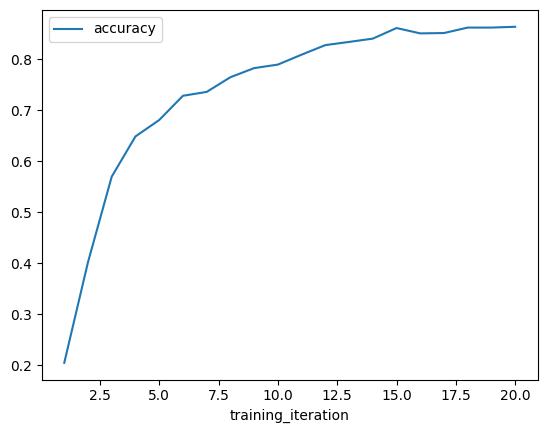

In [32]:
results.metrics_dataframe.plot("training_iteration", "accuracy")

In [58]:
from ray.train.tensorflow import TensorflowCheckpoint, TensorflowPredictor
from ray.train.batch_predictor import BatchPredictor

result_checkpoint: TensorflowCheckpoint = results.checkpoint
predictor = TensorflowPredictor.from_checkpoint(
    result_checkpoint, model_definition=build_cnn_model
)

In [135]:
_, (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# The `x` arrays are in uint8 and have values in the [0, 255] range.
# You need to convert them to float32 with values in the [0, 1] range.
x_test = x_test / np.float32(255)
y_test = y_test.astype(np.int64)

Predicted Class = 7


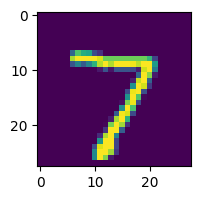

In [137]:
import matplotlib.pyplot as plt

test_img = x_test[0:1,:,:]
plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape((28, 28)))

predicted_class = np.argmax(predictor.predict(test_img)['predictions'])
print("Predicted Class =", predicted_class)

### Shutdown

In [138]:
ray.shutdown()

In [139]:
ray_cluster.kill()